In [ ]:
import tensorflow as tf
import numpy as np
import math
import matplotlib.pyplot as plt 
import pandas as pd
import random

from __future__ import absolute_import,division,print_function,unicode_literals
from IPython.display import clear_output
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from tensorflow import keras


In [ ]:
def Read_File( Training_filename , TestData_filename ):
    df = pd.read_csv(Training_filename)
    df_test = pd.read_csv(TestData_filename)


    hidden=df_test

    Isotope_List = list(df.pop('Isotope'))
    df_test.pop('Isotope')


    return df , df_test , Isotope_List
   


In [ ]:
def gaussian_noise( Data , mu , std ):
    noise = np.random.normal(mu, std, size = Data.shape)
    Noisy_Data = Data + noise
    return Noisy_Data 

#This function adds guassian noise to the data which is used to create a digital twin.

#'Data' is the input data that the noise is going to be apply to , 'mu' is the mean , and 'std' is standard deviation.  

In [ ]:
def Exp_form( X0 ,decay_constant , t ):

    X = X0 * math.e**(-decay_constant*t) 

    return  X 

#This funtion calculates the the change of X as a function of time using the exponetial decay formula

In [ ]:
def Create_Data_Set( df , df_test ):

    # Original_Half_Life and Test_Original_Half_Life are just an array of the original Half-Life in days before the Digital twin is created

    Original_Half_Life = np.array( ( df['Days'] ))
    
    Test_Original_Half_Life =np.array( ( df_test['Days'] )) 

    #The two loops below create 

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

    #input the number the times you want the training data to be replicated with a guassian noise (currently set to 1000) Total number of rows = 1000* (Oringinal amount of rows )

    for i in range(1000): 
        
        Noisey_Half_Life = gaussian_noise(Original_Half_Life , mu , std)        

        Noisey_Decay = ( np.log(2) ) / Noisey_Half_Life

        Noisey_Data = pd.DataFrame( {'Days' : Noisey_Half_Life , 'Decay_Constant' : Noisey_Decay } )

        df = pd.concat([df, Noisey_Data] )

    #The number the times you want the testing data to be replicated with a guassian noise (currently set to 1000). Total number of rows = 1000 * (Oringinal amount of rows )

    for i in range(1000):  
        Noisey_Test_Half_Life = gaussian_noise(Test_Original_Half_Life , mu , std)

        Noisey_Test_Decay = ( np.log(2) ) / Noisey_Test_Half_Life

        Noisey_Test_Data = pd.DataFrame( {'Days' : Noisey_Test_Half_Life , 'Decay_Constant' : Noisey_Test_Decay } )

        df_test = pd.concat([df_test , Noisey_Test_Data])

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
    df.reset_index(inplace = True, drop = True)
    df_test.reset_index(inplace= True, drop = True)

    print('Complete Step #1 ')   

    index_start=0

    index_end= len(Original_Half_Life) 

    Decay_data = list(df['Decay_Constant'])

    Test_Decay_data =list(df_test['Decay_Constant'])

    #For each isotopes decay constant, model the decay as a funtion of time
    # range(round(max(df['Days'])*10)) takes the largest half life in the data set, multiplys by 10 then rounds it to make sure its a whole number... that is the maximum amount of time the test is going to be runnning for increasing by increments of 5

    #The for loop simulates the dacay of each element and appends it to df

    for  t in range(0,round(max(df['Days'])*10),5):
    
        

        Moving_Data=[ Exp_form ( N0 , decay_constant , t  ) for decay_constant in Decay_data]

        Moving_Test_Data=[ Exp_form ( N0 , decay_constant , t  ) for decay_constant in Test_Decay_data]

        
        interval_data = pd.DataFrame({ str(t) : Moving_Data  })
        test_interval_data = pd.DataFrame({ str(t) : Moving_Test_Data  })

        

        df = pd.concat([ df , interval_data ],axis=1 )
        df_test = pd.concat([ df_test , test_interval_data ] ,axis=1)

        index_start +=len( Original_Half_Life )
        index_end+=len( Original_Half_Life )

    print('Complete step #2')   

    #Make the list of radioactive isotope names and replaces them with a list of numberical values corresponding to the name of the Isotopes        

    
    Numeric_Isotope_Identifications=[]
    Test_Numeric_Isotope_Identifications=[]

 #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    for  i in range( int( len(df)/len(Original_Half_Life) ) ):

        [Numeric_Isotope_Identifications.append(j) for j in range(len( Original_Half_Life ))]

    for i in range ( int(len(df_test)/len(Test_Original_Half_Life) ) ):
        [Test_Numeric_Isotope_Identifications.append(j) for j in range(len( Test_Original_Half_Life ))]


 #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#


        
    Numeric_Isotope_Identifications = pd.DataFrame({ 'Isotope' : Numeric_Isotope_Identifications } )
    Test_Numeric_Isotope_Identifications = pd.DataFrame({ 'Isotope' : Test_Numeric_Isotope_Identifications } )
   
    
    df = pd.concat( [df , Numeric_Isotope_Identifications] , axis=1 )
    df_test = pd.concat( [df_test , Test_Numeric_Isotope_Identifications] , axis=1 )


    return df , df_test , Isotope_List

In [ ]:
def Plot_Data_Frame(df , df_test):

    Row_list=[]
    X_values = list(df.columns.values)

    for index, rows in df.iterrows():
        # Create list for the current row

        plt.plot(X_values , list(df.iloc[index]) )

    plt.show()
    plt.close('all')

In [ ]:
def input_fn(features, labels, training=True, batch_size=256):
    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))

    # Shuffle and repeat if you are in training mode.
    if training:
        dataset = dataset.shuffle(1000).repeat()
    
    return dataset.batch(batch_size)


In [ ]:
def training ( df , df_train ,Isotope_List ):

    #Training uses a hidden markov model 
    my_feature_columns = []
    for key in df.keys():
        my_feature_columns.append(tf.feature_column.numeric_column(key=key))
    print(my_feature_columns)

    model = tf.estimator.DNNClassifier(
                feature_columns=my_feature_columns,
                # Two hidden layers of 128 and 64 nodes respectively. 256,128
                hidden_units=[128,64],
                # The model must choose between the number of Isotopes in 'Isotope_List' classes.
                n_classes=len(Isotope_List))

    clear_output()
    
    model.train(
        input_fn=lambda: input_fn(df, df_train, training=True),
        steps=6000)

    clear_output()
    
    return model


In [ ]:
# Input the directory for the the Training and Testing CSV files #

Training_filename=str(r'Desired Spreadsheet.csv')
TestData_filename = str(r'Desired Spreadsheet_Test.csv')
mu=0.0
std = 0.01

N0=1

df , df_test , Isotope_List = Read_File( Training_filename,TestData_filename )


df , df_test , Isotope_List = Create_Data_Set(df,df_test)

df_train = df.pop('Isotope')
df_test_eval = df_test.pop('Isotope')

df.pop('Decay_Constant')
df.pop('Days')


results={}



model = training ( df , df_train ,Isotope_List  )

eval_result = model.evaluate(
    input_fn=lambda: input_fn(df_test, df_test_eval, training=False ))

print('\nTest set accuracy: {accuracy:0.3f}\n'.format(**eval_result))


results.update({'Results accuracy' : eval_result['accuracy']})

    

print(results)

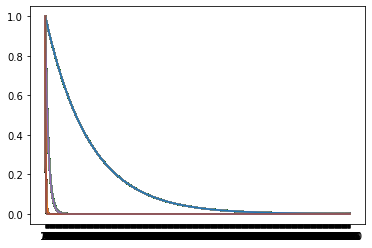

In [10]:
Plot_Data_Frame(df , df_test)